# Анализ рынка недвижимости России (поиск инсайтов, составление рекомендаций девелоперам и стейкхолдерам)

## Загрузить необходимые библиотеки и подгрузить файл

In [61]:
import pandas as pd
import numpy as np
import math
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy.stats import linregress

file_path = '/Users/A.Itsenkov/Documents/Учеба/диплом/input_data.csv'
data = pd.read_csv(file_path)

## Показать первые несколько строк данных для проверки

In [2]:
data = pd.read_csv(file_path, sep=';')
data.head(5)

,date,price,level,levels,rooms,area,kitchen_area,geo_lat,geo_lon,building_type,object_type,postal_code,street_id,id_region,house_id
0,2021-01-01,2451300,15,31,1,30.3,0.0,56.780112,60.699355,0,2,620000.0,NaN,66,1632918.0
1,2021-01-01,1450000,5,5,1,33.0,6.0,44.608154,40.138381,0,0,385000.0,NaN,1,NaN
2,2021-01-01,10700000,4,13,3,85.0,12.0,55.540060,37.725112,3,0,142701.0,242543.0,50,681306.0
3,2021-01-01,3100000,3,5,3,82.0,9.0,44.608154,40.138381,0,0,385000.0,NaN,1,NaN
4,2021-01-01,2500000,2,3,1,30.0,9.0,44.738685,37.713668,3,2,353960.0,439378.0,23,1730985.0


## Проверить типы данных

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11358150 entries, 0 to 11358149
Data columns (total 15 columns):
 #   Column         Dtype  
---  ------         -----  
 0   date           object 
 1   price          int64  
 2   level          int64  
 3   levels         int64  
 4   rooms          int64  
 5   area           float64
 6   kitchen_area   float64
 7   geo_lat        float64
 8   geo_lon        float64
 9   building_type  int64  
 10  object_type    int64  
 11  postal_code    float64
 12  street_id      float64
 13  id_region      int64  
 14  house_id       float64
dtypes: float64(7), int64(7), object(1)
memory usage: 1.3+ GB


## Зафиксировать описание колонок в датафрейме

#### date - Дата размещения объявления
#### price - Цена в рублях
#### level - Этаж
#### levels - Кол-во этажей в доме
#### rooms - Кол-во комнат. Если значение равно "-1", значит это "студия"
#### area - общая площадь квартиры
#### kitchen_area - площадь кухни
#### geo_lat - Ширина
#### geo_lon - Длина
#### building_type - Тип фасада: 
#### 0 - Неизвестно. 1 - Другой. 2 - Панель. 3 - Монолит. 4 - Кирпич. 5 - Блок. 6 - Дерево

# Очистка данных

##  Преобразовать цену с типа Int64 в float64

In [4]:
data['price'] = data['price'].astype(float)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11358150 entries, 0 to 11358149
Data columns (total 15 columns):
 #   Column         Dtype  
---  ------         -----  
 0   date           object 
 1   price          float64
 2   level          int64  
 3   levels         int64  
 4   rooms          int64  
 5   area           float64
 6   kitchen_area   float64
 7   geo_lat        float64
 8   geo_lon        float64
 9   building_type  int64  
 10  object_type    int64  
 11  postal_code    float64
 12  street_id      float64
 13  id_region      int64  
 14  house_id       float64
dtypes: float64(8), int64(6), object(1)
memory usage: 1.3+ GB


## Вывести описательную статистику для ознакомления данных

In [5]:
data.describe()

,price,level,levels,rooms,area,kitchen_area,geo_lat,geo_lon,building_type,object_type,postal_code,street_id,id_region,house_id
count,1.135815e+07,1.135815e+07,1.135815e+07,1.135815e+07,1.135815e+07,1.135815e+07,1.135815e+07,1.135815e+07,1.135815e+07,1.135815e+07,1.085038e+07,7.152596e+06,1.135815e+07,8.096207e+06
mean,6.787516e+06,6.426675e+00,1.176266e+01,1.719417e+00,5.310356e+01,-2.674071e+00,5.440394e+01,5.229570e+01,1.017820e+00,5.275366e-01,4.031717e+05,3.525623e+05,5.125515e+01,1.703792e+06
std,1.977118e+08,5.283144e+00,7.218441e+00,1.157606e+00,2.712845e+01,3.241855e+01,4.582962e+00,2.183899e+01,1.562077e+00,8.813503e-01,1.959618e+05,1.366485e+05,2.250527e+01,6.404578e+05
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,1.000000e+00,-1.000000e+02,4.143758e+01,-1.732189e+02,0.000000e+00,0.000000e+00,0.000000e+00,1.161870e+05,1.000000e+00,5.886060e+05
25%,2.600000e+06,2.000000e+00,5.000000e+00,1.000000e+00,3.650000e+01,0.000000e+00,5.319411e+01,3.763847e+01,0.000000e+00,0.000000e+00,1.961580e+05,2.339150e+05,3.100000e+01,1.162465e+06
50%,3.995000e+06,5.000000e+00,1.000000e+01,2.000000e+00,4.670000e+01,6.500000e+00,5.564688e+01,4.202111e+01,0.000000e+00,0.000000e+00,4.000070e+05,3.502220e+05,5.400000e+01,1.703143e+06
75%,6.500000e+06,9.000000e+00,1.700000e+01,2.000000e+00,6.300000e+01,1.050000e+01,5.687362e+01,6.547322e+01,2.000000e+00,2.000000e+00,6.250070e+05,4.705370e+05,7.200000e+01,2.255297e+06
max,6.355524e+11,5.000000e+01,5.000000e+01,9.000000e+00,4.999000e+02,4.080000e+02,7.350889e+01,1.792583e+02,6.000000e+00,2.000000e+00,8.621630e+05,5.885970e+05,2.000000e+02,2.839173e+06


#### Для начала приведем описательную статистику в удобный режим чтения, поменяв формат экспоненциальной записи в стандартный вид

In [6]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
data.describe()

,price,level,levels,rooms,area,kitchen_area,geo_lat,geo_lon,building_type,object_type,postal_code,street_id,id_region,house_id
count,11358150.00,11358150.00,11358150.00,11358150.00,11358150.00,11358150.00,11358150.00,11358150.00,11358150.00,11358150.00,10850379.00,7152596.00,11358150.00,8096207.00
mean,6787516.41,6.43,11.76,1.72,53.10,-2.67,54.40,52.30,1.02,0.53,403171.66,352562.33,51.26,1703792.31
std,197711828.43,5.28,7.22,1.16,27.13,32.42,4.58,21.84,1.56,0.88,195961.84,136648.51,22.51,640457.78
min,0.00,0.00,0.00,-1.00,1.00,-100.00,41.44,-173.22,0.00,0.00,0.00,116187.00,1.00,588606.00
25%,2600000.00,2.00,5.00,1.00,36.50,0.00,53.19,37.64,0.00,0.00,196158.00,233915.00,31.00,1162465.00
50%,3995000.00,5.00,10.00,2.00,46.70,6.50,55.65,42.02,0.00,0.00,400007.00,350222.00,54.00,1703143.00
75%,6500000.00,9.00,17.00,2.00,63.00,10.50,56.87,65.47,2.00,2.00,625007.00,470537.00,72.00,2255297.00
max,635552400000.00,50.00,50.00,9.00,499.90,408.00,73.51,179.26,6.00,2.00,862163.00,588597.00,200.00,2839173.00


#### У нас есть отрицательные значения, в которых нужно поменять знак с минуса на плюс. Это столбики kitchen_area и geo_lon. Из условия есть информация что в столбике rooms значение -1 означает студия. Примем за факт что студия это однокомнатная квартира, поэтому также поменяем отрицательные значения на положительные в этой колонке

## Поменять минусовые значения на положительные в столбиках rooms, kitchen_area, geo_lon и проверить результат. 

In [7]:
data['rooms'] = data['rooms'].abs()
data['kitchen_area'] = data['kitchen_area'].abs()
data['geo_lon'] = data['geo_lon'].abs()
data.describe()

,price,level,levels,rooms,area,kitchen_area,geo_lat,geo_lon,building_type,object_type,postal_code,street_id,id_region,house_id
count,11358150.00,11358150.00,11358150.00,11358150.00,11358150.00,11358150.00,11358150.00,11358150.00,11358150.00,11358150.00,10850379.00,7152596.00,11358150.00,8096207.00
mean,6787516.41,6.43,11.76,1.87,53.10,16.56,54.40,52.30,1.02,0.53,403171.66,352562.33,51.26,1703792.31
std,197711828.43,5.28,7.22,0.90,27.13,28.00,4.58,21.84,1.56,0.88,195961.84,136648.51,22.51,640457.78
min,0.00,0.00,0.00,1.00,1.00,0.00,41.44,19.88,0.00,0.00,0.00,116187.00,1.00,588606.00
25%,2600000.00,2.00,5.00,1.00,36.50,0.00,53.19,37.64,0.00,0.00,196158.00,233915.00,31.00,1162465.00
50%,3995000.00,5.00,10.00,2.00,46.70,8.20,55.65,42.02,0.00,0.00,400007.00,350222.00,54.00,1703143.00
75%,6500000.00,9.00,17.00,2.00,63.00,13.00,56.87,65.47,2.00,2.00,625007.00,470537.00,72.00,2255297.00
max,635552400000.00,50.00,50.00,9.00,499.90,408.00,73.51,179.26,6.00,2.00,862163.00,588597.00,200.00,2839173.00


## Проверить незаполненные значения

In [8]:
data.isnull().sum()

date                   0
price                  0
level                  0
levels                 0
rooms                  0
area                   0
kitchen_area           0
geo_lat                0
geo_lon                0
building_type          0
object_type            0
postal_code       507771
street_id        4205554
id_region              0
house_id         3261943
dtype: int64

#### У нас есть три колонки где пропущено много данных. При наличии координат geo_lat и geo_lon у нас нет необходимости в колонках postal_code, street_id и house_id.  Так как в случае необходимости мы по координатам можем определить место продажи квартиры. Можно удалить в целом эти колонки, так как они не несут для нас информационной ценности.

## Удалить колонки postal_code, street_id и house_id. Проверить результат.

In [9]:
data = data.drop('street_id', axis=1)
data = data.drop('postal_code', axis=1)
data = data.drop('house_id', axis=1)
data.head()

,date,price,level,levels,rooms,area,kitchen_area,geo_lat,geo_lon,building_type,object_type,id_region
0,2021-01-01,2451300.00,15,31,1,30.30,0.00,56.78,60.70,0,2,66
1,2021-01-01,1450000.00,5,5,1,33.00,6.00,44.61,40.14,0,0,1
2,2021-01-01,10700000.00,4,13,3,85.00,12.00,55.54,37.73,3,0,50
3,2021-01-01,3100000.00,3,5,3,82.00,9.00,44.61,40.14,0,0,1
4,2021-01-01,2500000.00,2,3,1,30.00,9.00,44.74,37.71,3,2,23


## Удалить все строки где значения по колонке price равняются нулю

In [10]:
data = data[data['price'] != 0]
data.shape

(11350050, 12)

#### У нас вместо 11 358 150 значений осталось 11 350 050. Удалили порядка 8 тыс значений.

## Проверить и проработать выбросы по колонке price

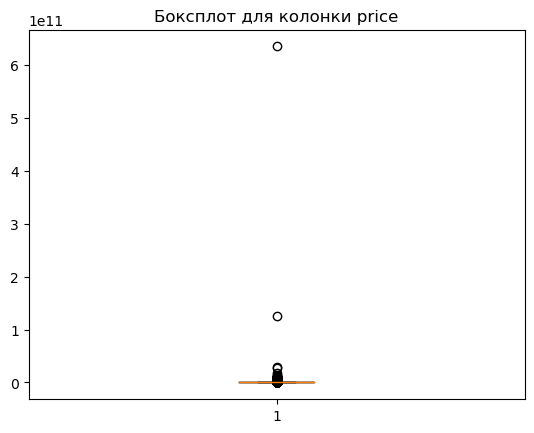

In [11]:
plt.boxplot(data['price'])
plt.title('Боксплот для колонки price')
plt.show()

#### видим аномальные значения - выбросы. Удалим 1% самых верхних и самых нижних выбросов и проверим график заново

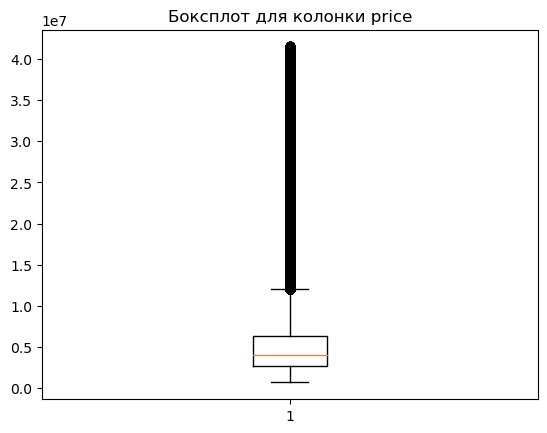

In [12]:
price_low = data['price'].quantile(0.01)
price_high  = data['price'].quantile(0.99)
data_final_price = data[(data['price'] < price_high) & (data['price'] > price_low)]
plt.boxplot(data_final_price['price'])
plt.title('Боксплот для колонки price')
plt.show()

## Проверить и проработать выбросы по остальным колонкам

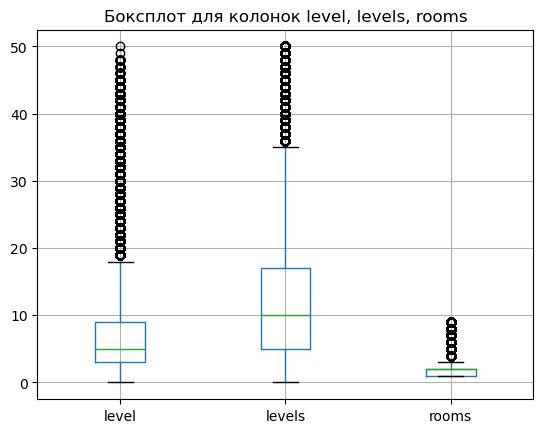

In [13]:
data_final_price[["level", "levels", "rooms"]].boxplot()
plt.title('Боксплот для колонок level, levels, rooms')
plt.show()

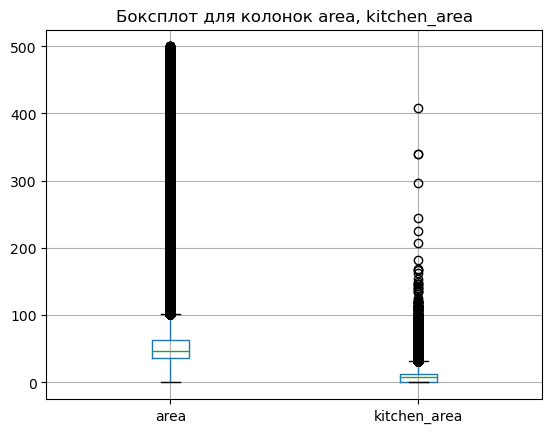

In [14]:
data_final_price[["area", "kitchen_area"]].boxplot()
plt.title('Боксплот для колонок area, kitchen_area')
plt.show()

#### Есть немного выбросов по колонке kitchen_area, но это можно списать на устройство квартиры. Проверим условие, что площадь кухни не может быть больше чем общая площадь квартиры.  

In [15]:
count_area_less_kitchen = (data_final_price['kitchen_area'] > data_final_price['area']).sum()
count_area_less_kitchen

1003039

#### У нас есть очень много квартир, в которых площадь кухни больше, чем общая площадь аппартаментов. Можно либо удалить все эти строки, либо поменять местами значения в этих двух колонках, списав некорректные данные на заслуги операциониста. Так как объем очень велик, то лучше заменить местами такие значения.

In [16]:
new_data = data_final_price.copy()
condition = new_data['kitchen_area'] > new_data['area']
new_data.loc[condition, ['kitchen_area', 'area']] = new_data.loc[condition, ['area', 'kitchen_area']].values
new_data.head()

,date,price,level,levels,rooms,area,kitchen_area,geo_lat,geo_lon,building_type,object_type,id_region
0,2021-01-01,2451300.00,15,31,1,30.30,0.00,56.78,60.70,0,2,66
1,2021-01-01,1450000.00,5,5,1,33.00,6.00,44.61,40.14,0,0,1
2,2021-01-01,10700000.00,4,13,3,85.00,12.00,55.54,37.73,3,0,50
3,2021-01-01,3100000.00,3,5,3,82.00,9.00,44.61,40.14,0,0,1
4,2021-01-01,2500000.00,2,3,1,30.00,9.00,44.74,37.71,3,2,23


## Проверить корректность заполнения по колонке id_region

In [17]:
new_data.id_region.unique()

array([ 66,   1,  50,  23,  34,  54,   3,  58,  77,  72,  78,  76,   2,
        40,  73,  18,  48,  27,  41,  63,  38,  15,  10,  39,  86,  16,
        47,   7,  26,   5,  91,  52,  56,  36,   9,  33,  31,  24,  74,
        22,  17,  43,  32,  64,  59,  46,  44,  61,  42,  12,  71,  57,
        29,  37,  21,  92,  51,  19,  70,  30,  75,  13,  69,  62,   8,
        35,  28,  68,  14,  20,  45,  55,  67,  25,  89,  11,  53,  60,
         6,  65,  49,   4, 200,  87,  83,  79])

In [18]:
region_200_data = new_data[new_data['id_region'] == 200]
region_200_data.shape

(3543, 12)

#### Обратим внимание что у нас есть максимальный регион 200. В России на данный момент всего 89 регионов. Будем считать что 200 регион это некорректные данные и удалим их из датафрейма, тем более таких значений у нас мало.

In [19]:
new_data = new_data[new_data['id_region'] != 200]
new_data.shape

(11113712, 12)

## Удалить дубликаты записей.

In [20]:
new_data.duplicated().sum()

401428

In [21]:
final_data = new_data.drop_duplicates()
final_data.shape

(10712284, 12)

## Подготовить датасет для исследовательского анализа добавив колонку с названием региона

In [22]:
regions = {
    1: 'Республика Адыгея',
    2: 'Республика Башкортостан', 
    3: 'Республика Бурятия',
    4: 'Республика Алтай',
    5: 'Республика Дагестан',
    6: 'Республика Ингушетия',
    7: 'Кабардино-Балкарская Республика',
    8: 'Республика Калмыкия',
    9: 'Карачаево-Черкесская Республика',
    10: 'Республика Карелия',
    11: 'Республика Коми',
    12: 'Республика Марий Эл', 
    13: 'Республика Мордовия', 
    14: 'Республика Саха', 
    15: 'Республика Северная Осетия-Алания', 
    16: 'Республика Татарстан', 
    17: 'Республика Тыва',
    18: 'Удмуртская Республика',
    19: 'Республика Хакасия',
    20: 'Чеченская Республика',
    21: 'Чувашская Республика',
    22: 'Алтайский край',
    23: 'Краснодарский край',
    24: 'Красноярский край',
    25: 'Приморский край',
    26: 'Ставропольский край',
    27: 'Хабаровский край',
    28: 'Амурская область',
    29: 'Архангельская область',
    30: 'Астраханская область',
    31: 'Белгородская область',
    32: 'Брянская область',
    33: 'Владимирская область',
    34: 'Волгоградская область',
    35: 'Вологодская область',
    36: 'Воронежская область',
    37: 'Ивановская область',
    38: 'Иркутская область',
    39: 'Калининградская область',
    40: 'Калужская область',
    41: 'Камчатский край',
    42: 'Кемеровская область',
    43: 'Кировская область',
    44: 'Костромская область',
    45: 'Курганская область',
    46: 'Курская область',
    47: 'Ленинградская область',
    48: 'Липецкая область',
    49: 'Магаданская область',
    50: 'Московская область',
    51: 'Мурманская область',
    52: 'Нижегородская область',
    53: 'Новгородская область',
    54: 'Новосибирская область',
    55: 'Омская область',
    56: 'Оренбургская область',
    57: 'Орловская область',
    58: 'Пензенская область',
    59: 'Пермский край',
    60: 'Псковская область',
    61: 'Ростовская область',
    62: 'Рязанская область',
    63: 'Самарская область',
    64: 'Саратовская область',
    65: 'Сахалинская область',
    66: 'Свердловская область',
    67: 'Смоленская область',
    68: 'Тамбовская область',
    69: 'Тверская область',
    70: 'Томская область',
    71: 'Тульская область',
    72: 'Тюменская область',
    73: 'Ульяновская область',
    74: 'Челябинская область',
    75: 'Забайкальский край',
    76: 'Ярославская область',
    77: 'Город Москва',
    78: 'Город Санкт-Петербург',
    79: 'Еврейская автономная область',
    83: 'Ненецкий автономный округ',
    86: 'Ханты-Мансийский автономный округ',
    87: 'Чукотский автономный округ',
    89: 'Ямало-Ненецкий автономный округ',
    91: 'Республика Крым',
    92: 'Город Севастополь'
}
final_df = final_data.copy()
final_df['region_name'] = final_df['id_region'].map(regions)
final_df.head()

,date,price,level,levels,rooms,area,kitchen_area,geo_lat,geo_lon,building_type,object_type,id_region,region_name
0,2021-01-01,2451300.00,15,31,1,30.30,0.00,56.78,60.70,0,2,66,Свердловская область
1,2021-01-01,1450000.00,5,5,1,33.00,6.00,44.61,40.14,0,0,1,Республика Адыгея
2,2021-01-01,10700000.00,4,13,3,85.00,12.00,55.54,37.73,3,0,50,Московская область
3,2021-01-01,3100000.00,3,5,3,82.00,9.00,44.61,40.14,0,0,1,Республика Адыгея
4,2021-01-01,2500000.00,2,3,1,30.00,9.00,44.74,37.71,3,2,23,Краснодарский край


# Исследовательский анализ

## Вывести топ 10 регионов по количеству продаж

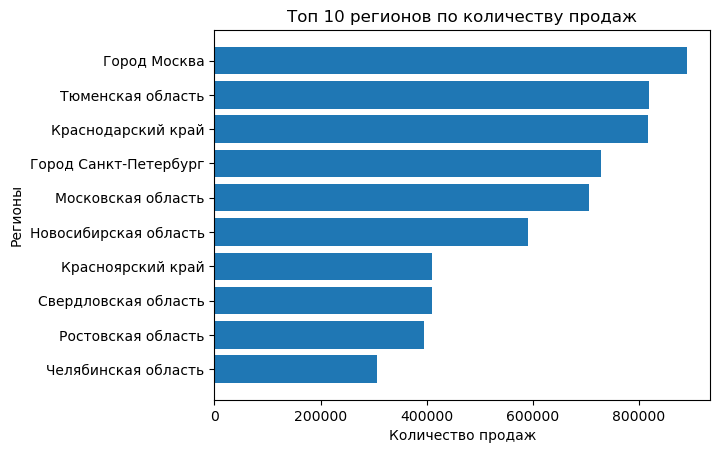

In [23]:
sales_in_region = final_df['region_name'].value_counts().sort_values(ascending=True).tail(10)
plt.barh(sales_in_region.index, sales_in_region.values)
plt.xlabel('Количество продаж')
plt.ylabel('Регионы')
plt.title('Топ 10 регионов по количеству продаж')
plt.show()

#### Вывод: можем увидеть популярность регионов как для жизни потенциальных клиентов так и для инвестиций наших стейкхолдеров

## Вывести минимальные и максимальные цены объектов для каждого региона, показать лидеров

In [24]:
final_df.groupby('region_name', as_index=False).agg(min_price = ("price", "min"))

,region_name,min_price
0,Алтайский край,705000.00
1,Амурская область,720000.00
2,Архангельская область,710000.00
3,Астраханская область,710000.00
4,Белгородская область,710000.00
...,...,...
80,Чеченская Республика,750000.00
81,Чувашская Республика,705000.00
82,Чукотский автономный округ,800000.00
83,Ямало-Ненецкий автономный округ,750000.00


In [25]:
top_10_min = final_df.sort_values(by = 'price', ascending=True) 
top_10_min[['region_name', 'price']].head(10)

,region_name,price
10565130,Республика Башкортостан,700001.00
11284299,Кабардино-Балкарская Республика,700002.00
2877173,Кабардино-Балкарская Республика,700003.00
9440529,Кабардино-Балкарская Республика,700004.00
9202353,Республика Татарстан,700020.00
4249684,Новосибирская область,700050.00
7695331,Краснодарский край,700100.00
9089320,Рязанская область,700200.00
7527083,Свердловская область,700202.00
7500668,Свердловская область,700202.00


In [26]:
final_df.groupby('region_name', as_index=True).agg(max_price = ("price", "max"))

,max_price
region_name,
Алтайский край,37500000.00
Амурская область,39994600.00
Архангельская область,32500000.00
Астраханская область,34000000.00
Белгородская область,40000000.00
...,...
Чеченская Республика,32000000.00
Чувашская Республика,37500000.00
Чукотский автономный округ,13000000.00


In [27]:
top_10_max = final_df.sort_values(by = 'price', ascending=False) 
top_10_max[['region_name', 'price']].head(10)

,region_name,price
9005902,Город Москва,41499999.00
8177521,Город Москва,41499015.00
8176813,Город Москва,41499015.00
7300178,Московская область,41499000.00
11200081,Московская область,41499000.00
1848734,Город Санкт-Петербург,41499000.00
2644433,Город Санкт-Петербург,41499000.00
215511,Город Москва,41497600.00
5343492,Город Санкт-Петербург,41496692.00
9981118,Город Санкт-Петербург,41496692.00


#### Вывод: минимальные и максимальные цены могут значительно варьироваться от региона к региону. Это может быть связано с различиями в инфраструктуре, уровне жизни, удаленностью от крупных городов и так далее. Выявление лидеров может помочь выявить предпочтения покупателей. Регионы с низкими ценами могут представлять интерес для инвесторов, исследующих возможности для роста стоимости недвижимости. С другой стороны, высокие цены могут свидетельствовать о популярности и высоком спросе на жилье в этих районах.

## Выявить для каждого региона средние цены объектов. Вывести регионы в которых наиболее минимальные и наиболее максимальные цены на квартиры

In [28]:
list_of_avg = final_df.groupby('region_name', as_index=False).agg(avg_price = ("price", "mean"))
list_of_avg.head()

,region_name,avg_price
0,Алтайский край,2967489.33
1,Амурская область,5037904.37
2,Архангельская область,3712472.15
3,Астраханская область,2934585.23
4,Белгородская область,3833270.55


In [29]:
top_5_max_avg = list_of_avg.nlargest(5, 'avg_price')
top_5_min_avg = list_of_avg.nsmallest(5, 'avg_price')

print("Топ 5 максимальных значений:")
print(top_5_max_avg)

print("\nТоп 5 минимальных значений:")
print(top_5_min_avg)

Топ 5 максимальных значений:
              region_name   avg_price
10           Город Москва 14395566.35
11  Город Санкт-Петербург  9229748.33
66    Сахалинская область  7600400.20
12      Город Севастополь  7229060.34
32     Московская область  6903944.84

Топ 5 минимальных значений:
                     region_name  avg_price
27            Курганская область 2071692.42
13  Еврейская автономная область 2395277.78
39          Оренбургская область 2435779.91
56           Республика Мордовия 2510765.89
55           Республика Марий Эл 2521892.84


#### Анализ средних и минимальных\максимальных цен по регионам предоставляет комплексное представление о рынке недвижимости и может помочь в принятии обоснованных стратегических решений в том числе с точки зрения привлекательности регионов и инвестиционных возможностей.

## Рассчитать модальные, медианные и средние значения по всем регионам

In [30]:
final_df.groupby(['region_name'])['price', 'level', 'levels', 'rooms', 'area'].agg(pd.Series.mode).reset_index() 

/var/folders/8d/y4scgnr16x95xzbjrlkvmnf40000gp/T/ipykernel_17346/3698910862.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  final_df.groupby(['region_name'])['price', 'level', 'levels', 'rooms', 'area'].agg(pd.Series.mode).reset_index()


,region_name,price,level,levels,rooms,area
0,Алтайский край,2500000.00,1,5,2,100.00
1,Амурская область,4500000.00,1,5,1,100.00
2,Архангельская область,3500000.00,2,5,2,100.00
3,Астраханская область,2500000.00,1,5,2,100.00
4,Белгородская область,3500000.00,1,9,1,100.00
...,...,...,...,...,...,...
80,Чеченская Республика,3500000.00,1,5,2,100.00
81,Чувашская Республика,2500000.00,1,9,1,100.00
82,Чукотский автономный округ,8500000.00,3,5,2,100.00
83,Ямало-Ненецкий автономный округ,5500000.00,1,9,1,100.00


In [31]:
final_df.groupby(['region_name'])['price', 'level', 'levels', 'rooms', 'area'].agg(pd.Series.median).reset_index()

/var/folders/8d/y4scgnr16x95xzbjrlkvmnf40000gp/T/ipykernel_17346/891841969.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  final_df.groupby(['region_name'])['price', 'level', 'levels', 'rooms', 'area'].agg(pd.Series.median).reset_index()


,region_name,price,level,levels,rooms,area
0,Алтайский край,2680000.00,4.00,9.00,2.00,51.10
1,Амурская область,4600000.00,3.00,5.00,2.00,55.00
2,Архангельская область,3490000.00,4.00,8.00,2.00,48.00
3,Астраханская область,2600000.00,4.00,5.00,2.00,57.00
4,Белгородская область,3600000.00,4.00,9.00,2.00,53.00
...,...,...,...,...,...,...
80,Чеченская Республика,3150000.00,4.00,5.00,2.00,100.00
81,Чувашская Республика,2500000.00,4.00,9.00,2.00,50.00
82,Чукотский автономный округ,4900000.00,3.00,5.00,2.00,59.50
83,Ямало-Ненецкий автономный округ,5700000.00,4.00,8.00,2.00,54.00


In [32]:
pd.options.display.float_format = '{:.2f}'.format
final_df.groupby(['region_name'])['price', 'level', 'levels', 'rooms', 'area'].agg(pd.Series.mean).reset_index()

/var/folders/8d/y4scgnr16x95xzbjrlkvmnf40000gp/T/ipykernel_17346/1922251116.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  final_df.groupby(['region_name'])['price', 'level', 'levels', 'rooms', 'area'].agg(pd.Series.mean).reset_index()


,region_name,price,level,levels,rooms,area
0,Алтайский край,2967489.33,5.52,10.10,1.98,58.17
1,Амурская область,5037904.37,4.12,7.28,1.90,62.40
2,Архангельская область,3712472.15,4.19,7.32,2.03,54.27
3,Астраханская область,2934585.23,4.41,7.39,2.09,62.59
4,Белгородская область,3833270.55,4.67,8.15,2.07,58.53
...,...,...,...,...,...,...
80,Чеченская Республика,3724714.07,4.45,7.17,2.38,81.15
81,Чувашская Республика,2873109.88,5.28,9.39,1.81,56.82
82,Чукотский автономный округ,5075018.76,3.13,4.79,2.14,67.34
83,Ямало-Ненецкий автономный округ,5941943.17,4.05,6.92,1.98,55.31


#### Общий инсайт: Если мода четко выражена в важном для стейкхолдера регионе, это может указывать на характерные для особенности этого региона. Например, это массовая однотипная застройка, от которой сейчас пытаются избавиться владельцы. Медиана может быть полезна в случае самых разных диапазонов цен, при наличии очень дешевого или очень премиального жилья и может дать представление о центре распределения, найти некую золотую середину, что также может быть полезно для инвесторов. Среднее значение может быть кривым при наличии существенных выбросов, но мы от них в целом избавились, поэтому, этот показатель тоже может существенно раскрыть информацию о регионе, насколько там отличается ценники от соседнего региона, а при наличии динамики - проверить рост в том или ином регионе.

## Рассчитать модальные, медианные и средние значения по Санкт-Петербургу

In [33]:
filtered_spb_df = final_df.query("region_name == 'Город Санкт-Петербург'")
filtered_spb_df.groupby(['region_name'])['price', 'level', 'levels', 'rooms', 'area'].agg(pd.Series.mode).reset_index()

/var/folders/8d/y4scgnr16x95xzbjrlkvmnf40000gp/T/ipykernel_17346/1483354321.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  filtered_spb_df.groupby(['region_name'])['price', 'level', 'levels', 'rooms', 'area'].agg(pd.Series.mode).reset_index()


,region_name,price,level,levels,rooms,area
0,Город Санкт-Петербург,6500000.00,2,5,1,100.00


In [34]:
filtered_spb_df.groupby(['region_name'])['price', 'level', 'levels', 'rooms', 'area'].agg(pd.Series.median).reset_index()

/var/folders/8d/y4scgnr16x95xzbjrlkvmnf40000gp/T/ipykernel_17346/2664591544.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  filtered_spb_df.groupby(['region_name'])['price', 'level', 'levels', 'rooms', 'area'].agg(pd.Series.median).reset_index()


,region_name,price,level,levels,rooms,area
0,Город Санкт-Петербург,7221430.00,6.00,13.00,1.00,50.00


In [36]:
filtered_spb_df.groupby(['region_name'])['price', 'level', 'levels', 'rooms', 'area'].agg(pd.Series.mean).reset_index()


/var/folders/8d/y4scgnr16x95xzbjrlkvmnf40000gp/T/ipykernel_17346/3679669801.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  filtered_spb_df.groupby(['region_name'])['price', 'level', 'levels', 'rooms', 'area'].agg(pd.Series.mean).reset_index()


,region_name,price,level,levels,rooms,area
0,Город Санкт-Петербург,9229748.33,7.47,14.00,1.74,58.27


#### Выводы:
#### 1. В Санкт-Петербурге наиболее часто можно встретить жильё, которое продаётся за 6 500 000, при чем медианное и среднее значение в этом городе выше, следовательно, активно продатся бюджетное жилье, эконом класса. Возможно, нашим инвесторам стоит обратить внимание и больше сориентироваться на жилье менее бюджетного варианта. 
#### 2. Медианная цена не чувствительна к выбросам, поэтому без наличия дополнительной информации такой как год постройки дома, ремонт и так далее - можно было бы со временем использовать как основную метрику для наблюдения тенденций в городе.
#### 3. Средняя цена выше медианной и модальной, что может быть свидетельством наличия высоких значений в распределении. Возможно, в некоторых регионах есть дорогие объекты недвижимости, которые влияют на среднюю цену.
#### 4. Что касается остальных данных типа этажности, площади - эта информация может быть полезна инвесторам, они помогают понять типичные характеристики в регионе и выявить аномалии. Например, у нас есть модальное значение по площади квартир 100, то есть наиболее часто попадаются квартиры, у которых площадь 100 квадратных метров. Возможно это аномалия, люди просто округляют свою площадь. Или, например, при средней этажности в доме в 14 этажей, у нас модальное значение равно 5. Можно сделать вывод, что люди пытаются чаще пытаются избавиться от квартир на 5 этаже. Так как в советское время часто стоили пятиэтажные дома, то это самый последний этаж, а на последнем этаже люди не очень любят покупать квартиры, из-за опасений в крыше.

## Рассчитать дисперсию и среднее отклонение по цене в регионах и Санкт-Петербурге в отдельности.

In [37]:
final_df.groupby(['region_name'])['price'].agg(['var', 'std']).reset_index()

,region_name,var,std
0,Алтайский край,2623930584820.79,1619855.11
1,Амурская область,6909607043064.32,2628613.14
2,Архангельская область,3994631108430.15,1998657.33
3,Астраханская область,2982752168939.36,1727064.61
4,Белгородская область,3168732261759.13,1780093.33
...,...,...,...
80,Чеченская Республика,5126040264788.74,2264076.03
81,Чувашская Республика,2979019478282.13,1725983.63
82,Чукотский автономный округ,8770269575265.71,2961464.09
83,Ямало-Ненецкий автономный округ,7617420241133.25,2759967.43


In [38]:
filtered_spb_df.groupby(['region_name'])['price'].agg(['var', 'std']).reset_index()

,region_name,var,std
0,Город Санкт-Петербург,38221256229981.61,6182334.21


#### Дисперсия в регионах указывает на большой разброс данных относительно среднего значения.
#### СКО в регионах измеряет среднюю величину отклонения каждого значения от среднего значения. Оно также предоставляет информацию о стандартном разбросе данных.

#### Что касается Санкт-Петербурга, то дисперсия очень большая, следовательно, есть квартиры как очень дешевые, так и очень дорогие, большой разброс в данных.
#### Среднее отклонение в Санкт-Петербурге получилось в районе 6.2 млн руб. Следовательно,  большинство цен на квартиры в городе расположены в пределах примерно ±6.2 млн рублей от средней цены.

## Построить график средний цен по регионам

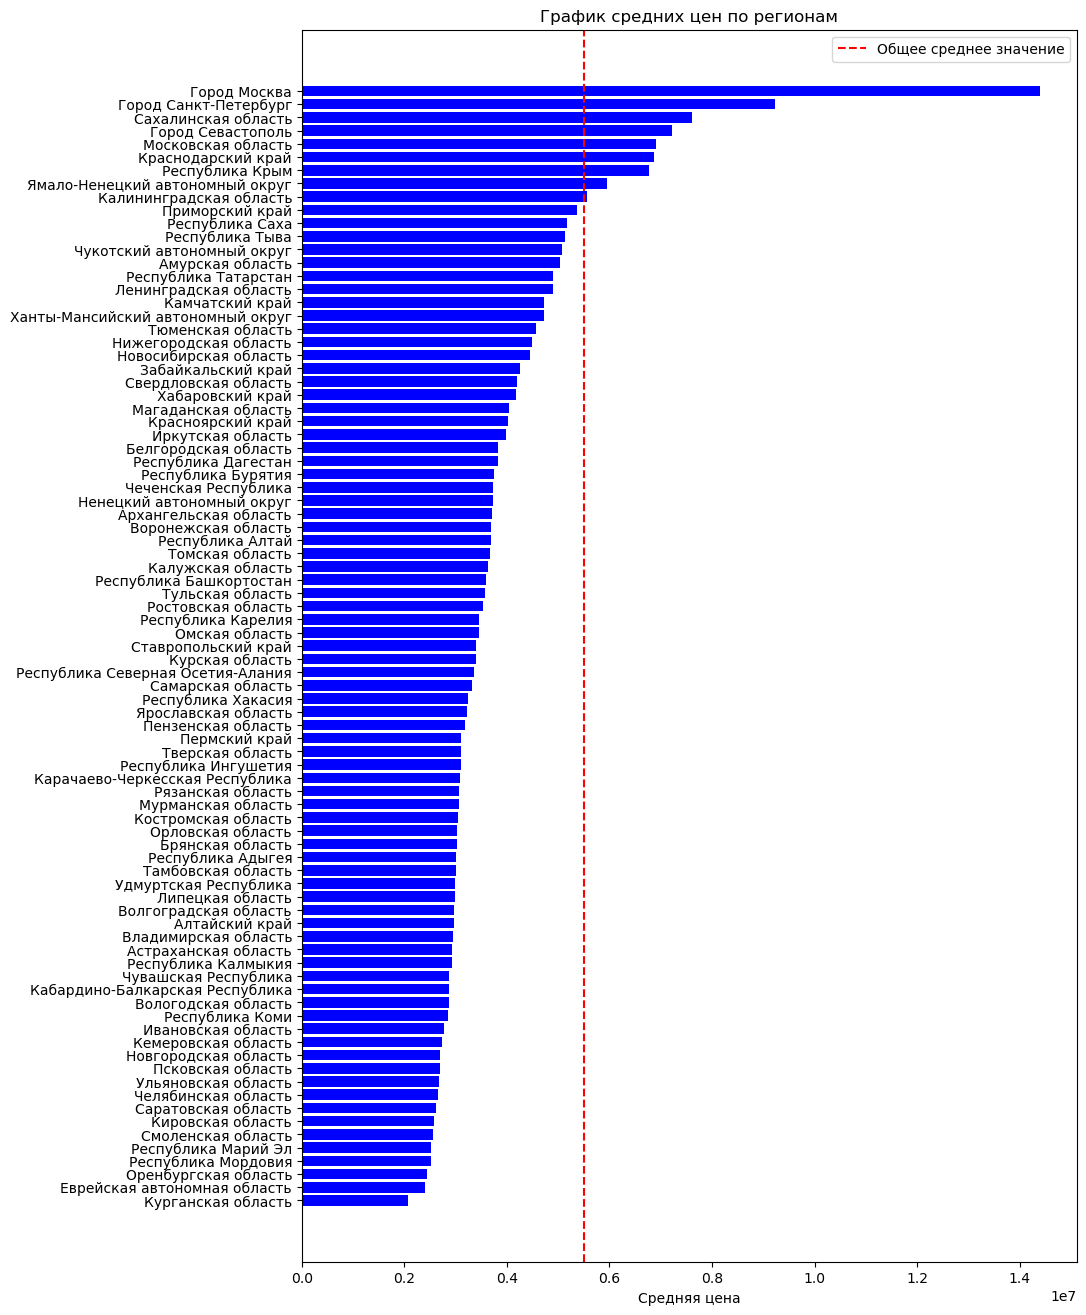

In [42]:
average_price_by_region = final_df.groupby(['region_name'])['price'].mean().reset_index()
overall_mean_price = final_df['price'].mean()
sorted_regions = average_price_by_region.sort_values(by='price', ascending=True)
fig, ax = plt.subplots(figsize=(10, 16))
ax.barh(sorted_regions['region_name'], sorted_regions['price'], color='blue')
ax.axvline(x=overall_mean_price, color='red', linestyle='--', label='Общее среднее значение')
ax.set_xlabel('Средняя цена')
ax.set_title('График средних цен по регионам')
ax.legend()
plt.show()

## Построить график цен по всем регионам

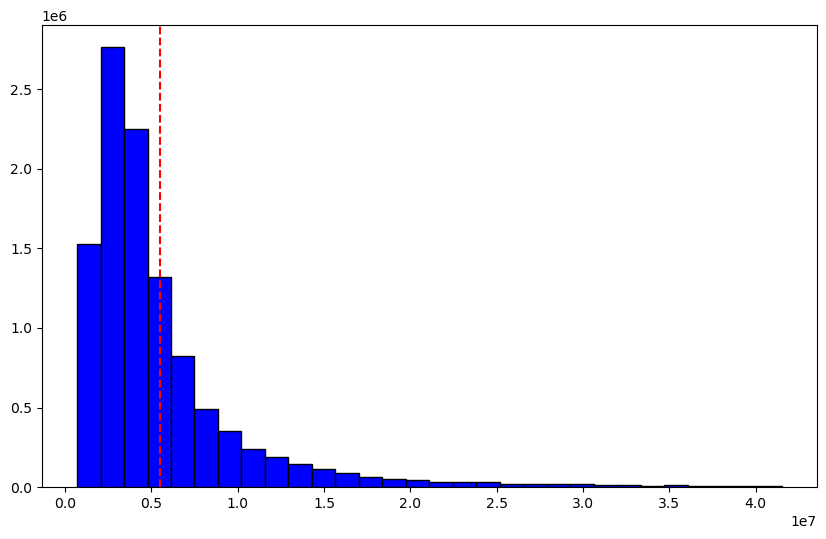

In [44]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(final_df['price'], bins=30, color='blue', edgecolor='black')
ax.axvline(x=overall_mean_price, color='red', linestyle='--', label='Mean Price')

#### Наш график подчиняется закону нормального распределения. Заметна асимметрия.

## Удалить все лишние столбцы (которые по нашему мнению не влияют на цену объекта) - id_region, region_name и date. Построить тепловую карту - матрицу корреляций для всех регионов и для Санкт-Петербурга в отдельности.

In [46]:
cor_df = final_df.drop(columns=['date', 'id_region', 'region_name'])
cor_df.head()

,price,level,levels,rooms,area,kitchen_area,geo_lat,geo_lon,building_type,object_type
0,2451300.00,15,31,1,30.30,0.00,56.78,60.70,0,2
1,1450000.00,5,5,1,33.00,6.00,44.61,40.14,0,0
2,10700000.00,4,13,3,85.00,12.00,55.54,37.73,3,0
3,3100000.00,3,5,3,82.00,9.00,44.61,40.14,0,0
4,2500000.00,2,3,1,30.00,9.00,44.74,37.71,3,2


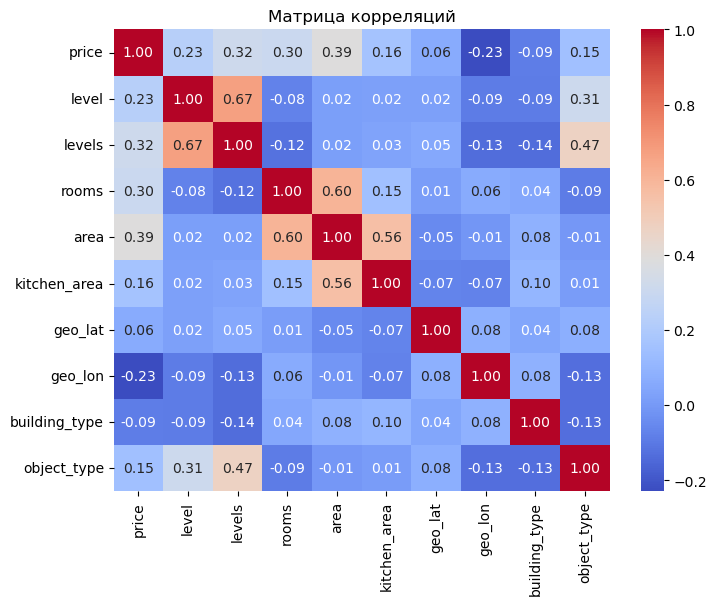

In [47]:
plt.figure(figsize=(8, 6))
sns.heatmap(cor_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Матрица корреляций')
plt.show()

#### Если смотреть взаимосвязь в целом по России, то наша матрица корреляций малоинформативна, нет коэффициента свыше 0.39 по отношению к цене объектов. Это говорит о том, что все наши переменные (например, плозадь, этаж или количество комнат) имеют некоторую степень взаимосвязи с ценой, но она не является очень сильной. 

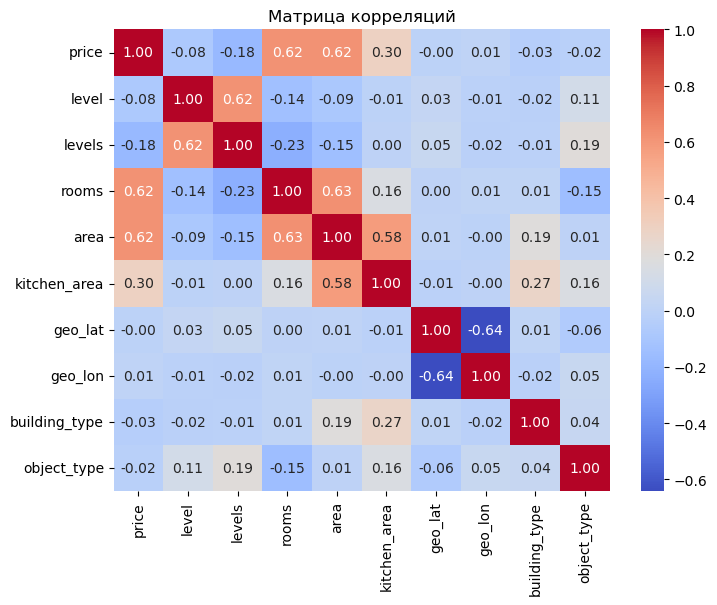

In [48]:
df_spb = final_df[final_df.region_name == 'Город Санкт-Петербург'].copy()
df_spb = df_spb.drop(columns=['date', 'id_region', 'region_name'])
plt.figure(figsize=(8, 6))
sns.heatmap(df_spb.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Матрица корреляций')
plt.show()

#### Если рассматривать коэффициенты корреляции по Санкт-Петербургу отдельно, то уже есть более четкая связь площади квартиры и соответственно наличие комнат с ценой, так как вполне логично, что чем больше площадь квартиры, тем больше комнат в этой квартире. 

## Построить график корреляции цены с площадью квартир по всем регионам и по Санкт-Петербургу в отдельности

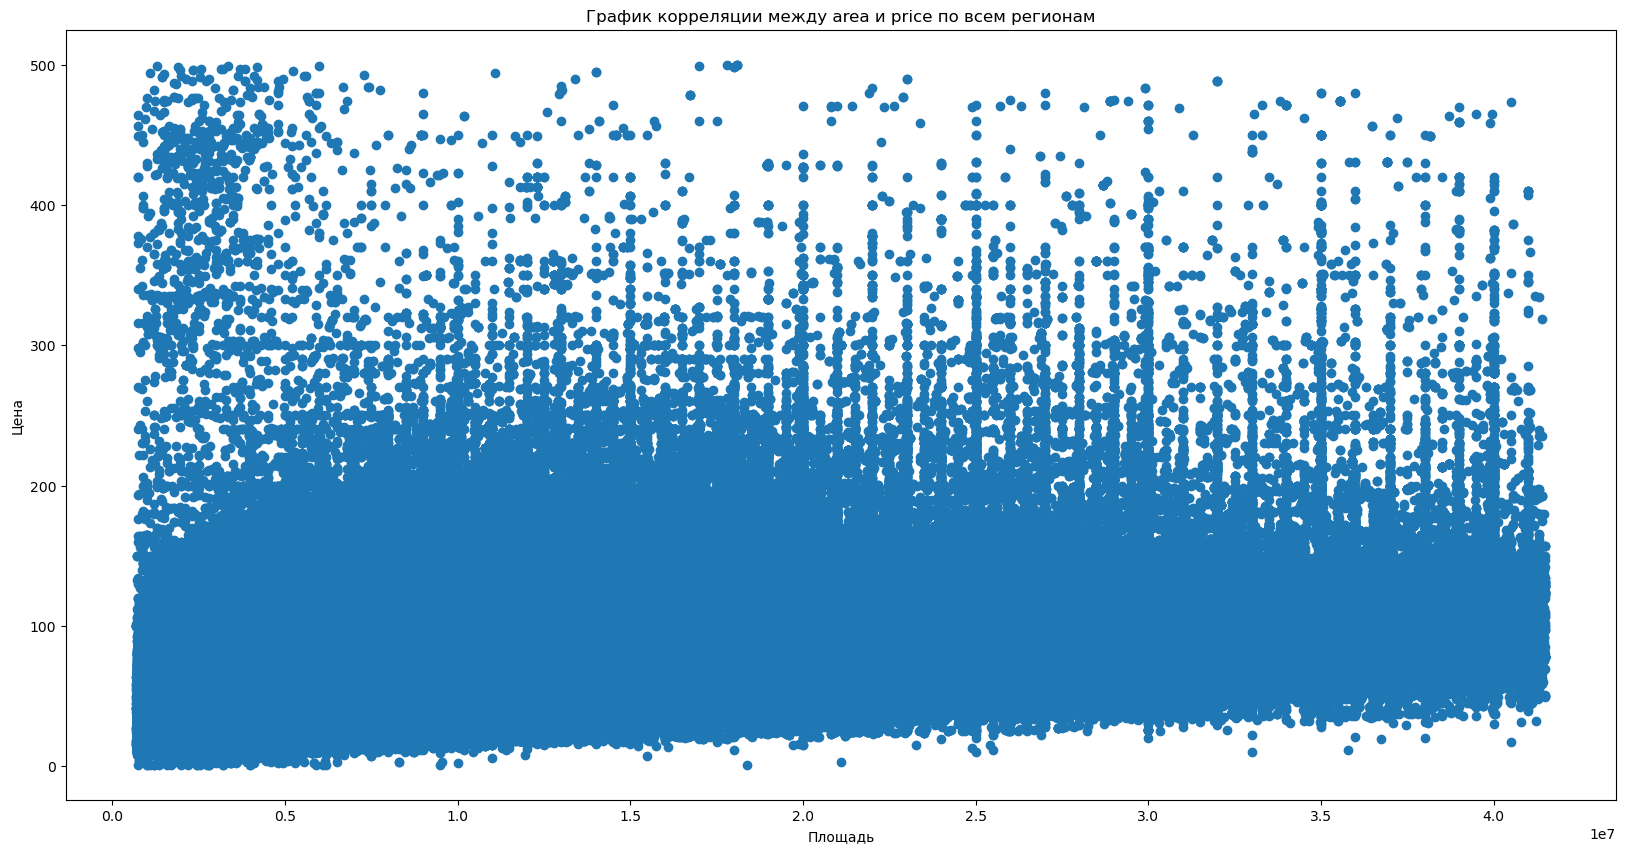

In [51]:
plt.figure(figsize=(20, 10))
plt.scatter(final_df['price'], final_df['area'])
plt.title('График корреляции между area и price по всем регионам')
plt.xlabel('Площадь')
plt.ylabel('Цена')
plt.show()

#### Этот график позволяет визуально оценить взаимосвязь между двумя переменными. Можно сделать несколько выводов: 
#### 1. Наш коэф корреляции указывает на наличие умеренной положительной линейной корреляции между переменными (цена и площадь).
#### 2. Разброс точек может указывать на различия в структуре рынка. В нашем случае практически нет дешевых квартир с большой площадью и тенденция сохраняется. 
#### 3. У нас нет аномальных выбросов, следовательно, очистку данных мы провели корректно.
#### 4. Продавцы любят округлять цифры при продаже объектов (можно заметить столбики над округленными цифрами.
#### 5. Есть небольшая плотность квартир в левом верхнем углу графика, то есть квартиры с минимальной площадью, которые стоят очень больших денег. Данная информация также могла бы быть интересна стейкхолдерам.

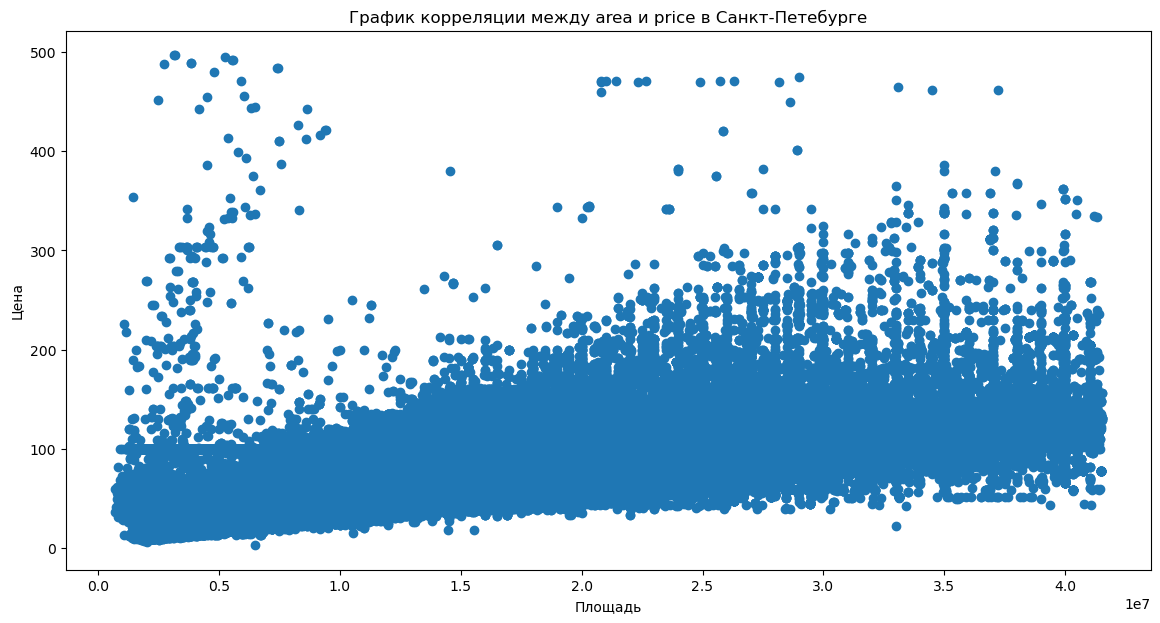

In [52]:
plt.figure(figsize=(14, 7))
plt.scatter(df_spb['price'], df_spb['area'])
plt.title('График корреляции между area и price в Санкт-Петебурге')
plt.xlabel('Площадь')
plt.ylabel('Цена')
plt.show()

#### На примере Санкт-Петербурга коэф корреляции между площадью и ценой становится более существенным, корреляция усиливается. Все предыдущие выводы также актуальны и для Санкт-Петербурга

## Построить линейную регрессию по Санкт-Петербургу и оценить качество модели

In [53]:
features = ['area', 'rooms', 'kitchen_area']
X = df_spb[features]
y = df_spb['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [58]:
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
print(f'RMSE на тренировочных данных: {rmse_train}')
print(f'RMSE на тестовых данных: {rmse_test}')

RMSE на тренировочных данных: 4518012.555023314
RMSE на тестовых данных: 4506067.633600734


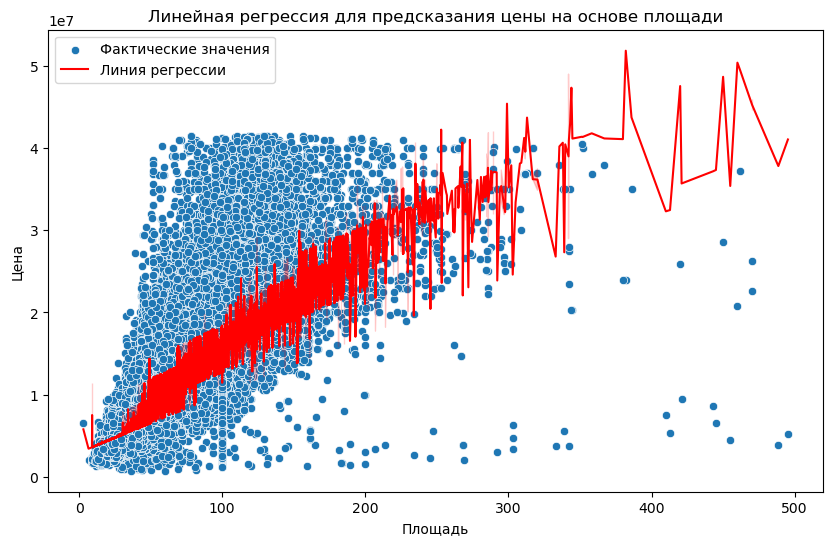

In [60]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_test['area'], y=y_test, label='Фактические значения')
sns.lineplot(x=X_test['area'], y=y_test_pred, color='red', label='Линия регрессии')
plt.xlabel('Площадь')
plt.ylabel('Цена')
plt.title('Линейная регрессия для предсказания цены на основе площади')
plt.legend()
plt.show()


#### Оба значения RMSE довольно велики, и это может указывать на то, что модель линейной регрессии не слишком успешно справляется с предсказанием цен. С учетом средней цены объявления более 9 млн руб, процентная ошибка будет равна почти 50%, что очень много. Чем меньше процентная ошибка RMSE, тем лучше модель предсказывает значения целевой переменной. Следовательно, таких данных как площадь квартиры/кухни и количество комнат достаточно мало, чтобы построить более способную модель регрессии.

In [62]:
# Гипотеза: чем больше людей живут в регионах - тем выше стоимость квартиры. 
# Для начала добавим данные по каждому региону (воспользуемся статьёй из википедии https://ru.wikipedia.org/wiki/%D0%9D%D0%B0%D1%81%D0%B5%D0%BB%D0%B5%D0%BD%D0%B8%D0%B5_%D1%81%D1%83%D0%B1%D1%8A%D0%B5%D0%BA%D1%82%D0%BE%D0%B2_%D0%A0%D0%BE%D1%81%D1%81%D0%B8%D0%B9%D1%81%D0%BA%D0%BE%D0%B9_%D0%A4%D0%B5%D0%B4%D0%B5%D1%80%D0%B0%D1%86%D0%B8%D0%B8)
Pop = {
    1: 497985,
    2: 4077600, 
    3: 974628,
    4: 210769,
    5: 3209781,
    6: 519078,
    7: 903266,
    8: 264483,
    9: 468444,
    10: 527880,
    11: 726434,
    12: 672321, 
    13: 771373, 
    14: 997565, 
    15: 680748, 
    16: 4001625, 
    17: 337271,
    18: 1442251,
    19: 530233,
    20: 1533209,
    21: 1173177,
    22: 2130950,
    23: 5819345,
    24: 2845545,
    25: 1820076,
    26: 2891204,
    27: 1284090,
    28: 756198,
    29: 1005687,
    30: 1005687,
    31: 1514527,
    32: 1152505,
    33: 1325510,
    34: 2470057,
    35: 1128782,
    36: 2285282,
    37: 914725,
    38: 2344360,
    39: 1032343,
    40: 1070853,
    41: 288730,
    42: 2568238,
    43: 1138112,
    44: 571900,
    45: 761586,
    46: 1067034,
    47: 2023767,
    48: 1126263,
    49: 134315,
    50: 8591736,
    51: 658698,
    52: 3081817,
    53: 575926,
    54: 2794266,
    55: 1832064,
    56: 1841377,
    57: 700276,
    58: 1246609,
    59: 2508352,
    60: 587786,
    61: 4164547,
    62: 1088918,
    63: 3142683,
    64: 2404944,
    65: 460535,
    66: 4239161,
    67: 873041,
    68: 966250,
    69: 1211183,
    70: 1052106,
    71: 1481471,
    72: 3851234,
    73: 1181006,
    74: 3407145,
    75: 992429,
    76: 1194605,
    77: 13104177,
    78: 5600044,
    79: 147458,
    83: 41383,
    86: 1730353,
    87: 47840,
    89: 512387,
    91: 1916805,
    92: 558273
}

In [63]:
final_df_h = final_data.copy()

In [64]:
final_df_h['Population'] = final_df['id_region'].map(Pop)

In [65]:
final_df_h.head(10)

,date,price,level,levels,rooms,area,kitchen_area,geo_lat,geo_lon,building_type,object_type,id_region,Population
0,2021-01-01,2451300.00,15,31,1,30.30,0.00,56.78,60.70,0,2,66,4239161
1,2021-01-01,1450000.00,5,5,1,33.00,6.00,44.61,40.14,0,0,1,497985
2,2021-01-01,10700000.00,4,13,3,85.00,12.00,55.54,37.73,3,0,50,8591736
3,2021-01-01,3100000.00,3,5,3,82.00,9.00,44.61,40.14,0,0,1,497985
4,2021-01-01,2500000.00,2,3,1,30.00,9.00,44.74,37.71,3,2,23,5819345
5,2021-01-01,1450000.00,5,5,2,47.00,6.00,48.51,44.57,2,0,34,2470057
6,2021-01-01,9000000.00,2,4,3,107.40,21.30,55.01,82.93,4,0,54,2794266
7,2021-01-01,2990000.00,1,2,3,54.00,7.00,51.83,107.60,0,0,3,974628
8,2021-01-01,2300000.00,16,18,1,39.70,11.50,45.00,39.09,4,0,23,5819345
9,2021-01-01,2290000.00,2,2,2,53.20,16.00,53.16,45.03,5,0,58,1246609


## Сформулировать и проверить гипотезу о влиянии количества человек проживающих в регионе на стоимость квартиры

#### Формулировка гипотезы
#### H0: наблюдаемая разница в стоимости квартир в регионах РФ обусловлена любыми иными факторами, кроме как количество человек проживающих в регионе
#### H1: наблюдаемая разница в стоимости квартир в регионах объясняется количеством человек живущих в регионе
#### Мы также выберем уровень значимости 0,05. Используем t-тест для проверки статистической значимости

In [66]:
from scipy.stats import linregress
price = final_df_h['price']
population = final_df_h['Population']
slope, intercept, r_value, p_value, std_err = linregress(population, price)
print(f"Slope (коэффициент наклона): {slope}")
print(f"P-value (значение p): {p_value}")
alpha = 0.05
if p_value < alpha:
    print("Отвергаем нулевую гипотезу. Существует статистически значимая связь между Population и Price.")
else:
    print("Не отвергаем нулевую гипотезу. Нет статистически значимой связи между Population и Price.")


Slope (коэффициент наклона): 0.8698214772085826
P-value (значение p): 0.0
Отвергаем нулевую гипотезу. Существует статистически значимая связь между Population и Price.


#### коэффициент наклона равен 0.8698, что означает, что при увеличении значения 'Population' на одну единицу, 
#### 'Price' увеличится в среднем на 0.8698 единицы (в предположении линейной зависимости).

#### Значение p-value равно 0.0, что меньше уровня значимости 0.05 (если вы использовали этот уровень). 
#### Маленькое значение p-value говорит о том, что у вас есть статистически значимые доказательства в пользу того, 
#### что коэффициент наклона не равен нулю (то есть есть зависимость между 'Population' и 'Price').

#### Таким образом, на основе этого анализа можно сделать вывод, что существует статистически значимая 
#### положительная зависимость между населением ('Population') и ценой ('Price').